In [1]:
import numpy as np
import pandas as pd
import shap
import torch
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [2]:
# Check GPU availability
print("TensorFlow GPU:", tf.config.list_physical_devices('GPU'))
print("Torch GPU:", torch.cuda.is_available())

TensorFlow GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Torch GPU: True


In [3]:
m1="CIC-IDS-2017/Monday-WorkingHours.pcap_ISCX.csv"
t1="CIC-IDS-2017/Tuesday-WorkingHours.pcap_ISCX.csv"
w1="CIC-IDS-2017/Wednesday-workingHours.pcap_ISCX.csv"
th1="CIC-IDS-2017/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv"
th2="CIC-IDS-2017/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv"
f1="CIC-IDS-2017/Friday-WorkingHours-Morning.pcap_ISCX.csv"
f2="CIC-IDS-2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"
f3="CIC-IDS-2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv"

dm1 = pd.read_csv(m1)
dt1 = pd.read_csv(t1)
dw1 = pd.read_csv(w1)
dth1 = pd.read_csv(th1)
dth2 = pd.read_csv(th2)
df1 = pd.read_csv(f1)
df2 = pd.read_csv(f2)
df3 = pd.read_csv(f3)

In [4]:
df = pd.concat([dm1,dt1,dw1,dth1,dth2,df1, df2, df3], axis=0)
#dm1,dt1,dw1,dth1,dth2,df1, df2, df3

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.dropna()

In [5]:
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])

class_names=le.classes_

In [6]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', tree_method='gpu_hist')
xgb.fit(X_train_scaled, y_train)

c:\Users\rishu\miniconda3\envs\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:33:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\rishu\miniconda3\envs\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:33:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [10]:
# Prepare data for LSTM (reshape for time series)
X_train_lstm = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_lstm = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

In [11]:
# Train LSTM on GPU
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.2),
    Dense(len(np.unique(y)), activation='softmax')  # Multi-class classification
])

In [12]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, validation_data=(X_test_lstm, y_test), verbose=1)


Epoch 1/10
70697/70697 [==============================] - 300s 4ms/step - loss: 0.0657 - accuracy: 0.9731 - val_loss: 0.0446 - val_accuracy: 0.9812
Epoch 2/10
70697/70697 [==============================] - 281s 4ms/step - loss: 0.0475 - accuracy: 0.9798 - val_loss: 0.0413 - val_accuracy: 0.9822
Epoch 3/10
70697/70697 [==============================] - 283s 4ms/step - loss: 0.0411 - accuracy: 0.9830 - val_loss: 0.0249 - val_accuracy: 0.9912
Epoch 4/10
70697/70697 [==============================] - 283s 4ms/step - loss: 0.0320 - accuracy: 0.9880 - val_loss: 0.0280 - val_accuracy: 0.9903
Epoch 5/10
70697/70697 [==============================] - 285s 4ms/step - loss: 0.0289 - accuracy: 0.9895 - val_loss: 0.0198 - val_accuracy: 0.9938
Epoch 6/10
70697/70697 [==============================] - 295s 4ms/step - loss: 0.0270 - accuracy: 0.9905 - val_loss: 0.0184 - val_accuracy: 0.9942
Epoch 7/10
70697/70697 [==============================] - 300s 4ms/step - loss: 0.0261 - accuracy: 0.9908 - val_

In [13]:
xgb_preds = xgb.predict(X_test_scaled)
lstm_preds = np.argmax(model.predict(X_test_lstm), axis=1)

c:\Users\rishu\miniconda3\envs\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
c:\Users\rishu\miniconda3\envs\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set th

17675/17675 [==============================] - 26s 1ms/step


In [19]:
model.save("models\lstm_model.h5")  # or "cnn_lstm_model.h5"


In [14]:
ensemble_preds = (xgb_preds + lstm_preds) / 2
ensemble_preds = np.round(ensemble_preds).astype(int)

In [15]:
accuracy = accuracy_score(y_test, ensemble_preds)
print(f"Ensemble Model Accuracy: {accuracy:.4f}")

Ensemble Model Accuracy: 0.9954


Precision: 0.9956
Recall: 0.9954
F1 Score: 0.9951


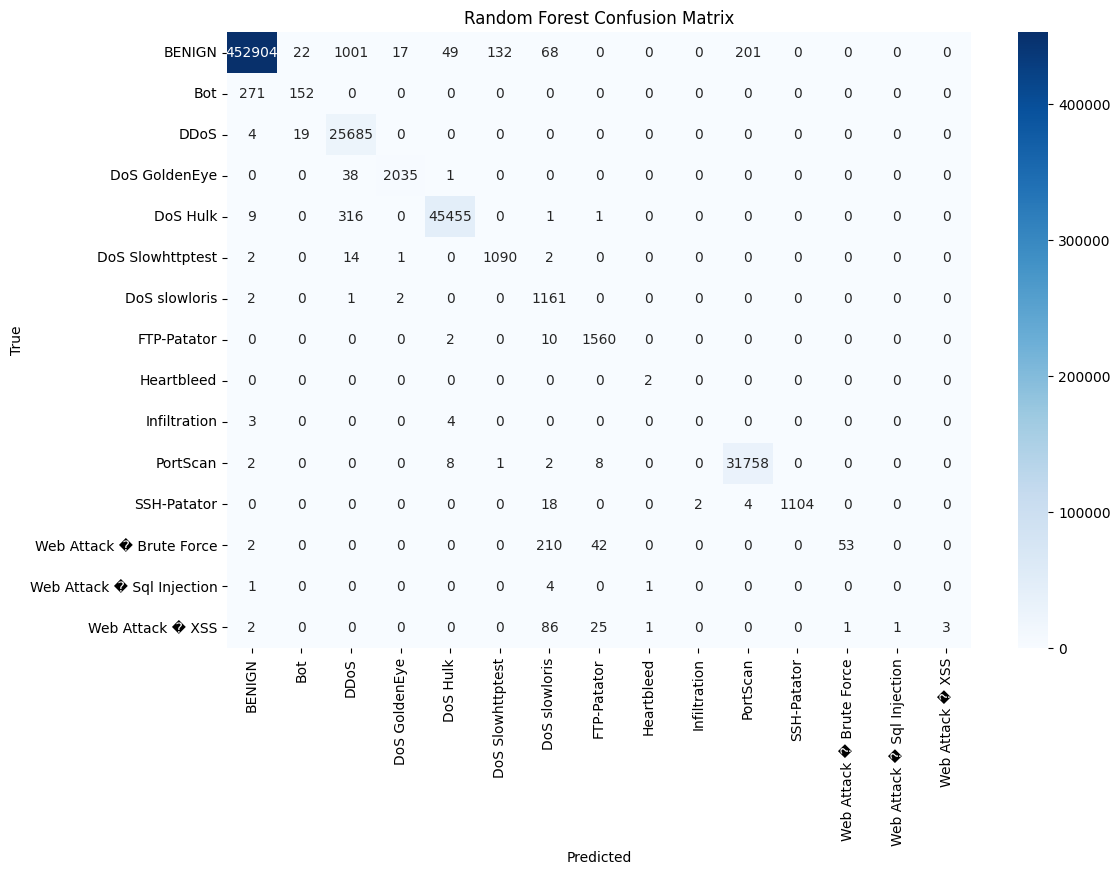


Classification Report:
                             precision    recall  f1-score   support

                    BENIGN   0.999342  0.996721  0.998030    454394
                       Bot   0.787565  0.359338  0.493506       423
                      DDoS   0.949362  0.999105  0.973599     25708
             DoS GoldenEye   0.990268  0.981196  0.985711      2074
                  DoS Hulk   0.998594  0.992857  0.995717     45782
          DoS Slowhttptest   0.891251  0.982867  0.934820      1109
             DoS slowloris   0.743278  0.995712  0.851173      1166
               FTP-Patator   0.953545  0.992366  0.972569      1572
                Heartbleed   0.500000  1.000000  0.666667         2
              Infiltration   0.000000  0.000000  0.000000         7
                  PortScan   0.993586  0.999339  0.996454     31779
               SSH-Patator   1.000000  0.978723  0.989247      1128
  Web Attack � Brute Force   0.981481  0.172638  0.293629       307
Web Attack � Sql Injec

In [18]:

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
conf_matrix = confusion_matrix(y_test, ensemble_preds)

# Precision, Recall, F1 Score
precision = precision_score(y_test, ensemble_preds , average='weighted')  # Use 'weighted' for imbalanced datasets
recall = recall_score(y_test, ensemble_preds, average='weighted')
f1 = f1_score(y_test, ensemble_preds, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot Confusion Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, ensemble_preds,digits=6,target_names=class_names))

c:\Users\rishu\miniconda3\envs\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [19:33:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


<Figure size 640x480 with 0 Axes>

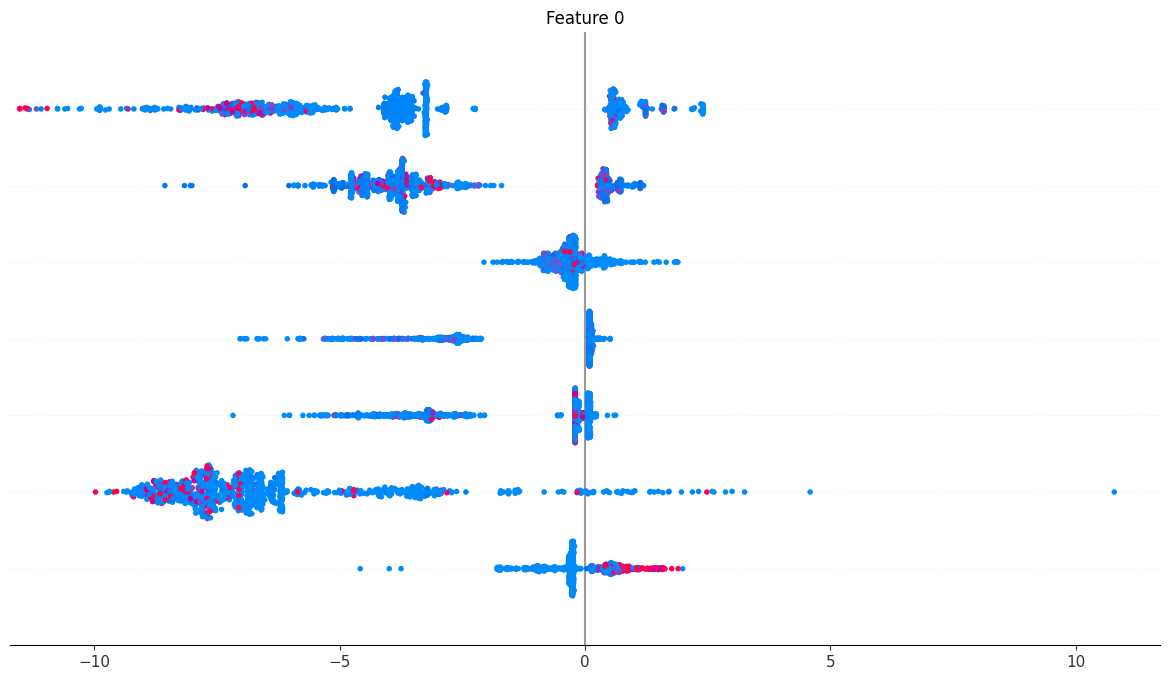

In [11]:
import shap

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_scaled[:1000])  # Select subset

# If multi-class, visualize SHAP for one class at a time
if isinstance(shap_values, list):
    for i in range(len(shap_values)):  # Iterate through classes
        print(f"SHAP Summary Plot for Class {i}")
        shap.summary_plot(shap_values[i], X_test_scaled[:1000])
else:
    shap.summary_plot(shap_values, X_test_scaled[:1000]) 


In [12]:
print("Shape of X_test_scaled[:1000]:", X_test_scaled[:1000].shape)
print("Shape of shap_values:", np.array(shap_values).shape)

Shape of X_test_scaled[:1000]: (1000, 78)
Shape of shap_values: (1000, 78, 15)


In [13]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import shap
import pandas as pd

print("Starting minimal SHAP analysis...")

# Create a smaller sample for analysis
sample_size = min(500, X_test_scaled.shape[0])
X_sample = X_test_scaled[:sample_size]

# Store feature names
feature_names = list(X.columns)
print(f"Number of features: {len(feature_names)}")
print(f"First few feature names: {feature_names[:5]}")

# Initialize SHAP explainer
print("Initializing SHAP explainer...")
explainer = shap.TreeExplainer(xgb)

# Calculate SHAP values
print("Calculating SHAP values...")
shap_values = explainer.shap_values(X_sample)

# Handle multi-class output
if isinstance(shap_values, list):
    print(f"Multi-class output detected with {len(shap_values)} classes")
    # For visualization, use first class
    shap_values_to_plot = shap_values[0]
    multi_class = True
else:
    print("Binary classification or regression detected")
    shap_values_to_plot = shap_values
    multi_class = False

print(f"Shape of SHAP values: {shap_values_to_plot.shape}")
print(f"Shape of input sample: {X_sample.shape}")

Starting minimal SHAP analysis...
Number of features: 78
First few feature names: [' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets']
Initializing SHAP explainer...
Calculating SHAP values...
Binary classification or regression detected
Shape of SHAP values: (500, 78, 15)
Shape of input sample: (500, 78)



Step 1: Creating summary bar plot...


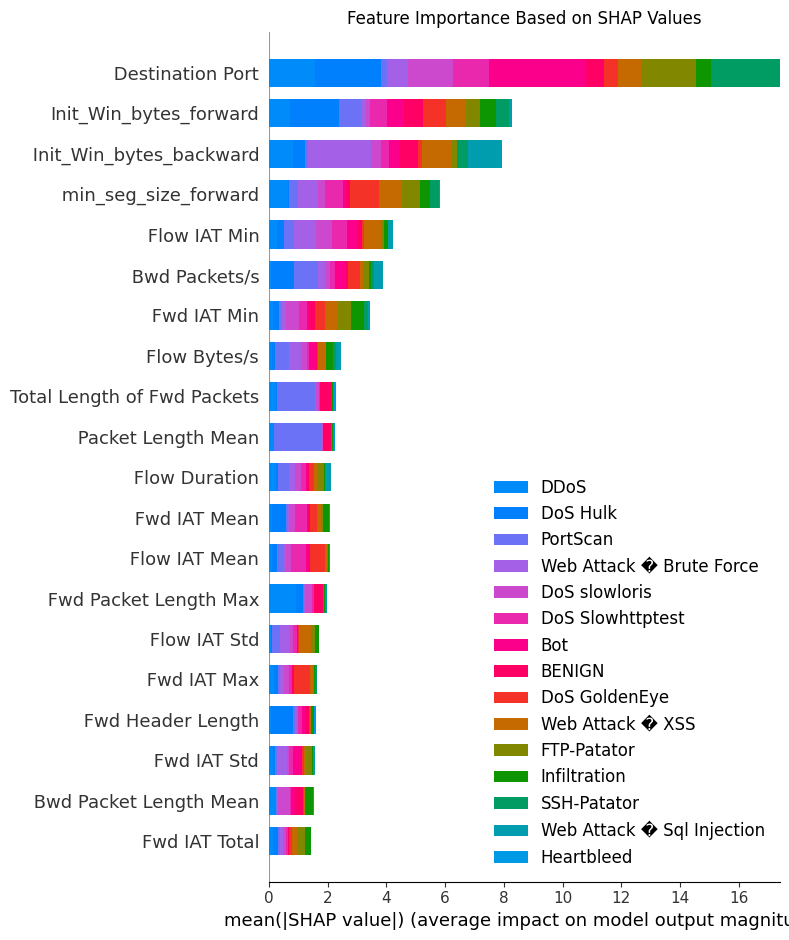

✓ Summary bar plot completed successfully


In [14]:
# Step 1: Basic summary bar plot
try:
    print("\nStep 1: Creating summary bar plot...")
    plt.figure(figsize=(12, 50))
    shap.summary_plot(
        shap_values_to_plot, 
        X_sample, 
        feature_names=feature_names, 
        class_names=class_names,
        plot_type="bar", 
        show=False
    )
    plt.title("Feature Importance Based on SHAP Values")
    plt.tight_layout()
    plt.savefig("1_shap_feature_importance_bar.png", dpi=300, bbox_inches='tight')
    plt.show()
    print("✓ Summary bar plot completed successfully")
except Exception as e:
    print(f"✗ Error in summary bar plot: {e}")


Step 2: Creating summary distribution plot...


<Figure size 1400x1200 with 0 Axes>

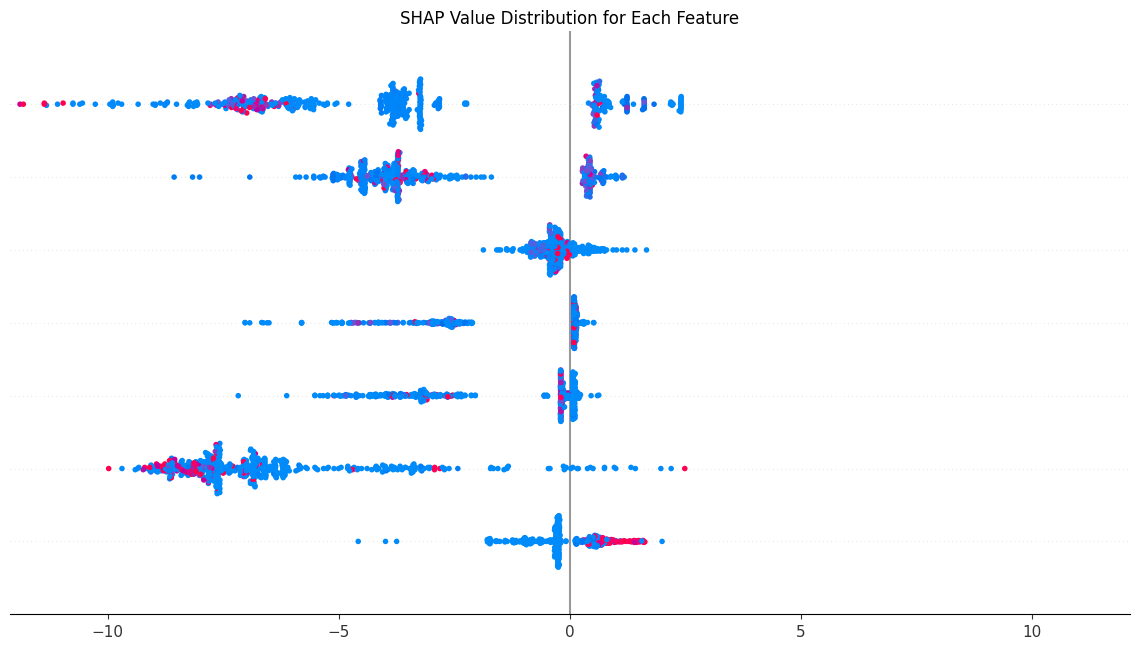

✓ Summary distribution plot completed successfully


In [15]:
# Step 2: Summary distribution plot
try:
    print("\nStep 2: Creating summary distribution plot...")
    plt.figure(figsize=(14, 12))
    shap.summary_plot(
        shap_values_to_plot, 
        X_sample, 
        feature_names=feature_names, 
        class_names=class_names,
        show=False
    )
    plt.title("SHAP Value Distribution for Each Feature")
    plt.tight_layout()
    plt.savefig("2_shap_value_distribution.png", dpi=300, bbox_inches="tight")
    plt.show()
    print("✓ Summary distribution plot completed successfully")
except Exception as e:
    print(f"✗ Error in summary distribution plot: {e}")

In [56]:
# Step 3: Calculate and display top features
try:
    print("\nStep 3: Identifying top features...")
    mean_abs_shap = np.abs(shap_values_to_plot).mean(axis=0)
    print(f"Shape of mean_abs_shap: {mean_abs_shap.shape}")
    
    # Get indices of top features
    top_indices = np.argsort(mean_abs_shap)[-5:].tolist()
    print(f"Top feature indices: {top_indices}")
    
    # Get names of top features
    top_feature_names = [feature_names[i] for i in top_indices]
    print(f"Top features by importance:\n{top_feature_names}")
    
    # Save this information
    with open("3_top_features.txt", "w") as f:
        f.write("Top 5 features by SHAP importance:\n")
        for i, feature in zip(top_indices, top_feature_names):
            f.write(f"{i}: {feature} - {mean_abs_shap[i]:.6f}\n")
    
    print("✓ Top features identified successfully")
except Exception as e:
    print(f"✗ Error identifying top features: {e}")


Step 3: Identifying top features...
Shape of mean_abs_shap: (78, 15)
Top feature indices: [[7, 8, 11, 12, 13, 14, 4, 9, 1, 5, 6, 3, 10, 0, 2], [1, 8, 11, 12, 13, 7, 14, 9, 0, 10, 6, 3, 5, 2, 4], [1, 7, 8, 11, 12, 13, 14, 9, 10, 6, 4, 0, 2, 3, 5], [1, 7, 8, 9, 10, 11, 12, 13, 14, 4, 0, 6, 5, 3, 2], [7, 8, 11, 13, 1, 6, 9, 14, 10, 0, 12, 5, 4, 3, 2]]
✗ Error identifying top features: list indices must be integers or slices, not list


In [58]:
# Step 4: Create individual dependence plots
try:
    print("\nStep 4: Creating individual dependence plots...")
    # Use only the top 5 feature indices
    for i in top_indices:
        try:
            plt.figure(figsize=(10, 8))
            print(f"  Creating plot for feature index {i}: {feature_names[i]}")
            
            # Use matplotlib directly for more control
            # Calculate the values for the plot manually
            x = X_sample[:, i]
            y = shap_values_to_plot[:, i]
            
            # Create scatter plot
            plt.scatter(x, y, alpha=0.6)
            plt.xlabel(f"Feature Value: {feature_names[i]}")
            plt.ylabel(f"SHAP Value: {feature_names[i]}")
            plt.title(f"SHAP Dependence Plot for {feature_names[i]}")
            plt.grid(True, linestyle='--', alpha=0.7)
            
            # Add trend line
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            plt.plot(np.sort(x), p(np.sort(x)), "r--", alpha=0.8)
            
            # Save the plot
            safe_name = feature_names[i].replace(' ', '_').replace('/', '_')
            plt.tight_layout()
            plt.savefig(f"4_dependence_{safe_name}.png", dpi=300, bbox_inches="tight")
            plt.show()
            print(f"  ✓ Plot for {feature_names[i]} completed")
        except Exception as e:
            print(f"  ✗ Error in dependence plot for feature {i}: {e}")
    
    print("✓ Dependence plots completed")
except Exception as e:
    print(f"✗ Error in dependence plots: {e}")


Step 4: Creating individual dependence plots...
  ✗ Error in dependence plot for feature [7, 8, 11, 12, 13, 14, 4, 9, 1, 5, 6, 3, 10, 0, 2]: list indices must be integers or slices, not list
  ✗ Error in dependence plot for feature [1, 8, 11, 12, 13, 7, 14, 9, 0, 10, 6, 3, 5, 2, 4]: list indices must be integers or slices, not list
  ✗ Error in dependence plot for feature [1, 7, 8, 11, 12, 13, 14, 9, 10, 6, 4, 0, 2, 3, 5]: list indices must be integers or slices, not list
  ✗ Error in dependence plot for feature [1, 7, 8, 9, 10, 11, 12, 13, 14, 4, 0, 6, 5, 3, 2]: list indices must be integers or slices, not list
  ✗ Error in dependence plot for feature [7, 8, 11, 13, 1, 6, 9, 14, 10, 0, 12, 5, 4, 3, 2]: list indices must be integers or slices, not list
✓ Dependence plots completed


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [59]:
# Step 5: Create a simple feature importance plot
try:
    print("\nStep 5: Creating feature importance plot...")
    # Get top 20 features
    top20_indices = np.argsort(mean_abs_shap)[-20:].tolist()
    top20_features = [feature_names[i] for i in top20_indices]
    top20_values = [mean_abs_shap[i] for i in top20_indices]
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'Feature': top20_features,
        'Importance': top20_values
    })
    importance_df = importance_df.sort_values('Importance')
    
    # Plot
    plt.figure(figsize=(12, 10))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Mean |SHAP Value|')
    plt.title('Top 20 Features by SHAP Importance')
    plt.tight_layout()
    plt.savefig("5_feature_importance.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    # Save data to CSV
    importance_df.to_csv('feature_importance.csv', index=False)
    
    print("✓ Feature importance plot completed successfully")
except Exception as e:
    print(f"✗ Error in feature importance plot: {e}")

print("\nSHAP analysis completed. Check the output files.")


Step 5: Creating feature importance plot...
✗ Error in feature importance plot: list indices must be integers or slices, not list

SHAP analysis completed. Check the output files.
